In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt

import pppc
from pppc.configs import PtychoNNTrainingConfigDict
from pppc.ptychonn.trainer import PtychoNNTrainer
from pppc.ptychonn.dataset_handle import HDF5Dataset
from pppc.ptychonn.model import PtychoNNModel
from pppc.helper import transform_data_for_ptychonn

[2023-12-12 20:24:44,085] Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[2023-12-12 20:24:44,089] NumExpr defaulting to 8 threads.


Define some data transform functions for handling raw training data with different sizes. 

In [3]:
# Raw DP size 512, label 128; crop DPs to 384, then rescale to 128. (use default function in HDF5Dataset)
transform_func_512_128 = None
transform_func_kwargs_512_128 = None

# Raw DP size 512, label 128; crop DPs to 256, then pad to 384, and rescale to 128. (use default function in HDF5Dataset)
def transform_func_512_128_pad(dp):
    dp = transform_data_for_ptychonn(dp, target_shape=(256, 256), discard_len=(128, 128))
    dp = transform_data_for_ptychonn(dp, target_shape=(128, 128), discard_len=(-64, -64))
    return dp
transform_func_kwargs_512_128_pad = None

In [4]:
config_dict = PtychoNNTrainingConfigDict()
config_dict['batch_size_per_process'] = 64
config_dict['num_epochs'] = 60
config_dict['learning_rate_per_process'] = 1e-4
config_dict['optimizer'] = 'adam'
config_dict['model_save_dir'] = '../../trained_models/model_36SpiralDatasets_cleaned'
config_dict['validation_ratio'] = 0.01
# Attention to transform_func and transform_func_kwargs. They must match the training data. 
dataset = HDF5Dataset('data/data_train.h5', verbose=False, transform_func=transform_func_512_128, transform_func_kwargs=transform_func_kwargs_512_128)
config_dict['dataset'] = dataset
config_dict['model'] = (PtychoNNModel, {'n_levels': 4})
config_dict['debug'] = False

Check some data distributions. 

[2023-12-12 20:24:50,300] 0 overflowing values corrected.


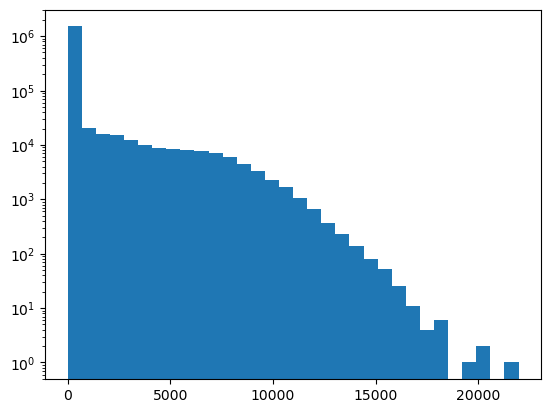

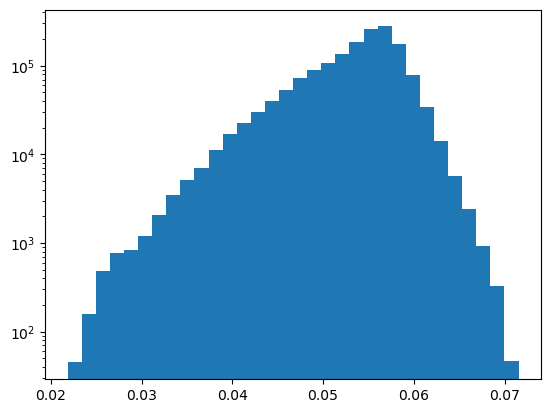

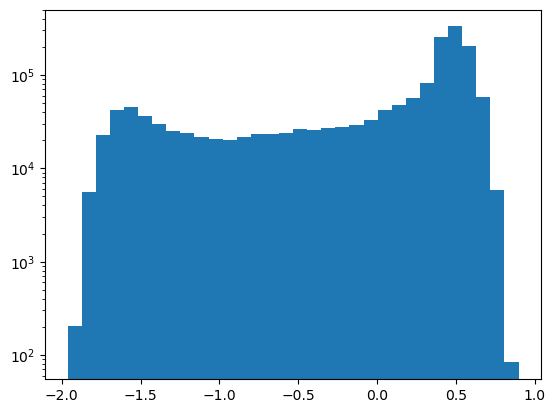

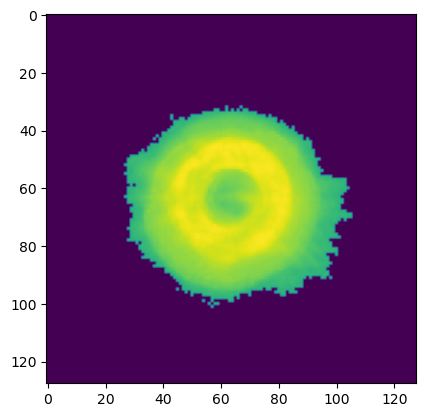

In [5]:
def plot_distribution(x):
    x = x.reshape(-1)
    #x = x[x > 0]
    plt.hist(x, bins=32)
    plt.semilogy()
    plt.show()

x, y_mag, y_ph = dataset.__getitems__(list(range(100)))
plot_distribution(x.numpy())
plot_distribution(y_mag.numpy())
plot_distribution(y_ph.numpy())
plt.imshow(np.log10(x[0, 0, :, :] + 1e-6))
plt.show()

In [6]:
trainer = PtychoNNTrainer(config_dict)
trainer.build()

[2023-12-12 20:25:08,089] Using DataParallel with 2 devices.


In [7]:
#print(trainer.model)
from torchsummary import summary
summary(trainer.model, (1, 256, 256), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             320
              ReLU-2         [-1, 32, 256, 256]               0
            Conv2d-3         [-1, 32, 256, 256]           9,248
              ReLU-4         [-1, 32, 256, 256]               0
         MaxPool2d-5         [-1, 32, 128, 128]               0
            Conv2d-6         [-1, 64, 128, 128]          18,496
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,928
              ReLU-9         [-1, 64, 128, 128]               0
        MaxPool2d-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]          73,856
             ReLU-12          [-1, 128, 64, 64]               0
           Conv2d-13          [-1, 128, 64, 64]         147,584
             ReLU-14          [-1, 128,

In [8]:
trainer.run_training()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 268/268 [05:20<00:00,  1.20s/it]
[2023-12-12 20:30:38,067] Saving improved model after Val Loss improved from inf to 0.58558
[2023-12-12 20:30:38,116] Epoch: 0 | FT  | Train Loss: 0.66949 | Val Loss: 0.58558
[2023-12-12 20:30:38,117] Epoch: 0 | Amp | Train Loss: 0.0975 | Val Loss: 0.0205
[2023-12-12 20:30:38,117] Epoch: 0 | Ph  | Train Loss: 0.572 | Val Loss: 0.565
[2023-12-12 20:30:38,118] Epoch: 0 | Ending LR: 0.000050 
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 268/268 [05:35<00:00,  1.25s/it]
[2023-12-12 20:36:16,815] Saving improved model after Val Los

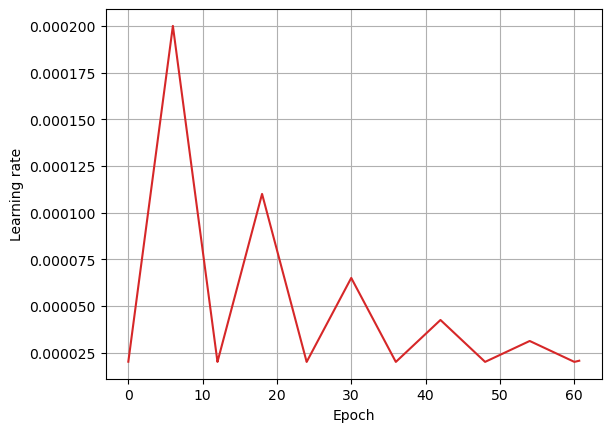

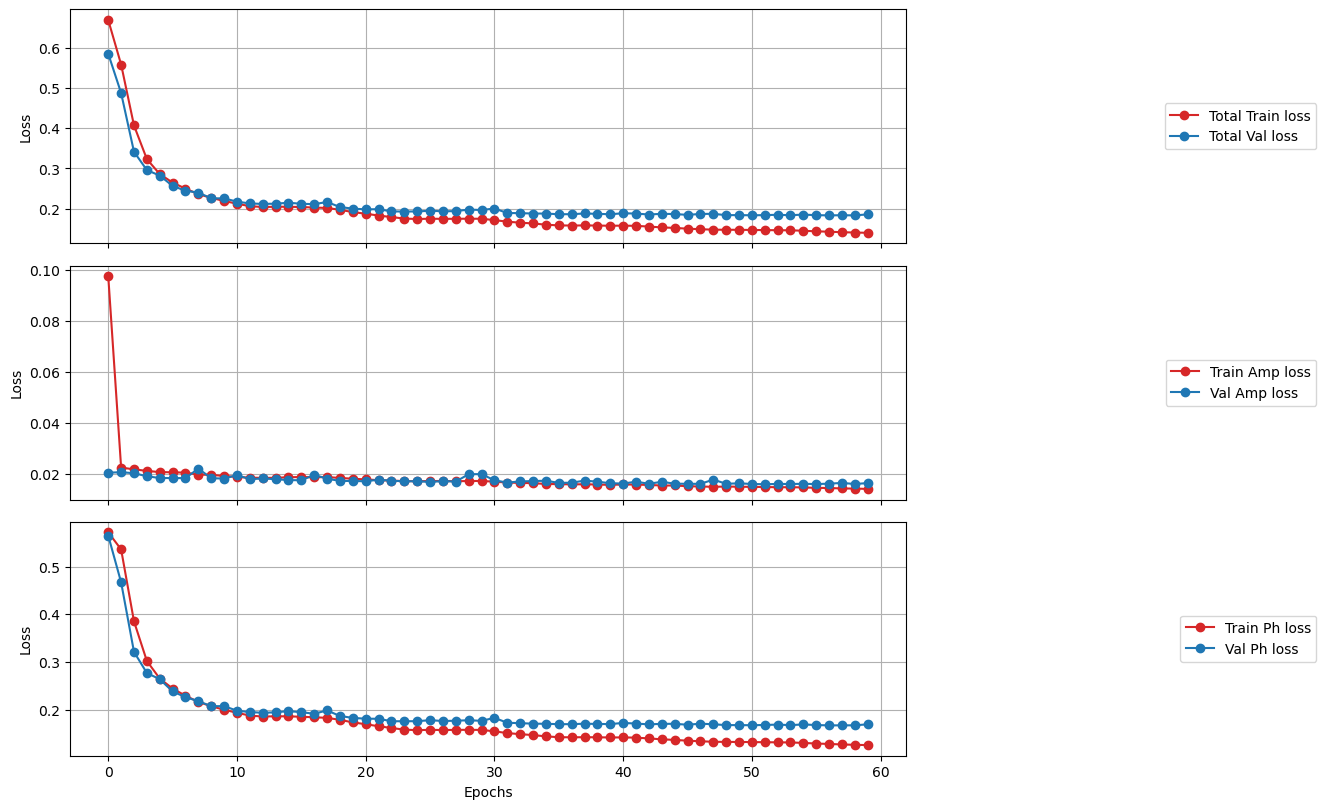

In [9]:
trainer.plot_training_history()

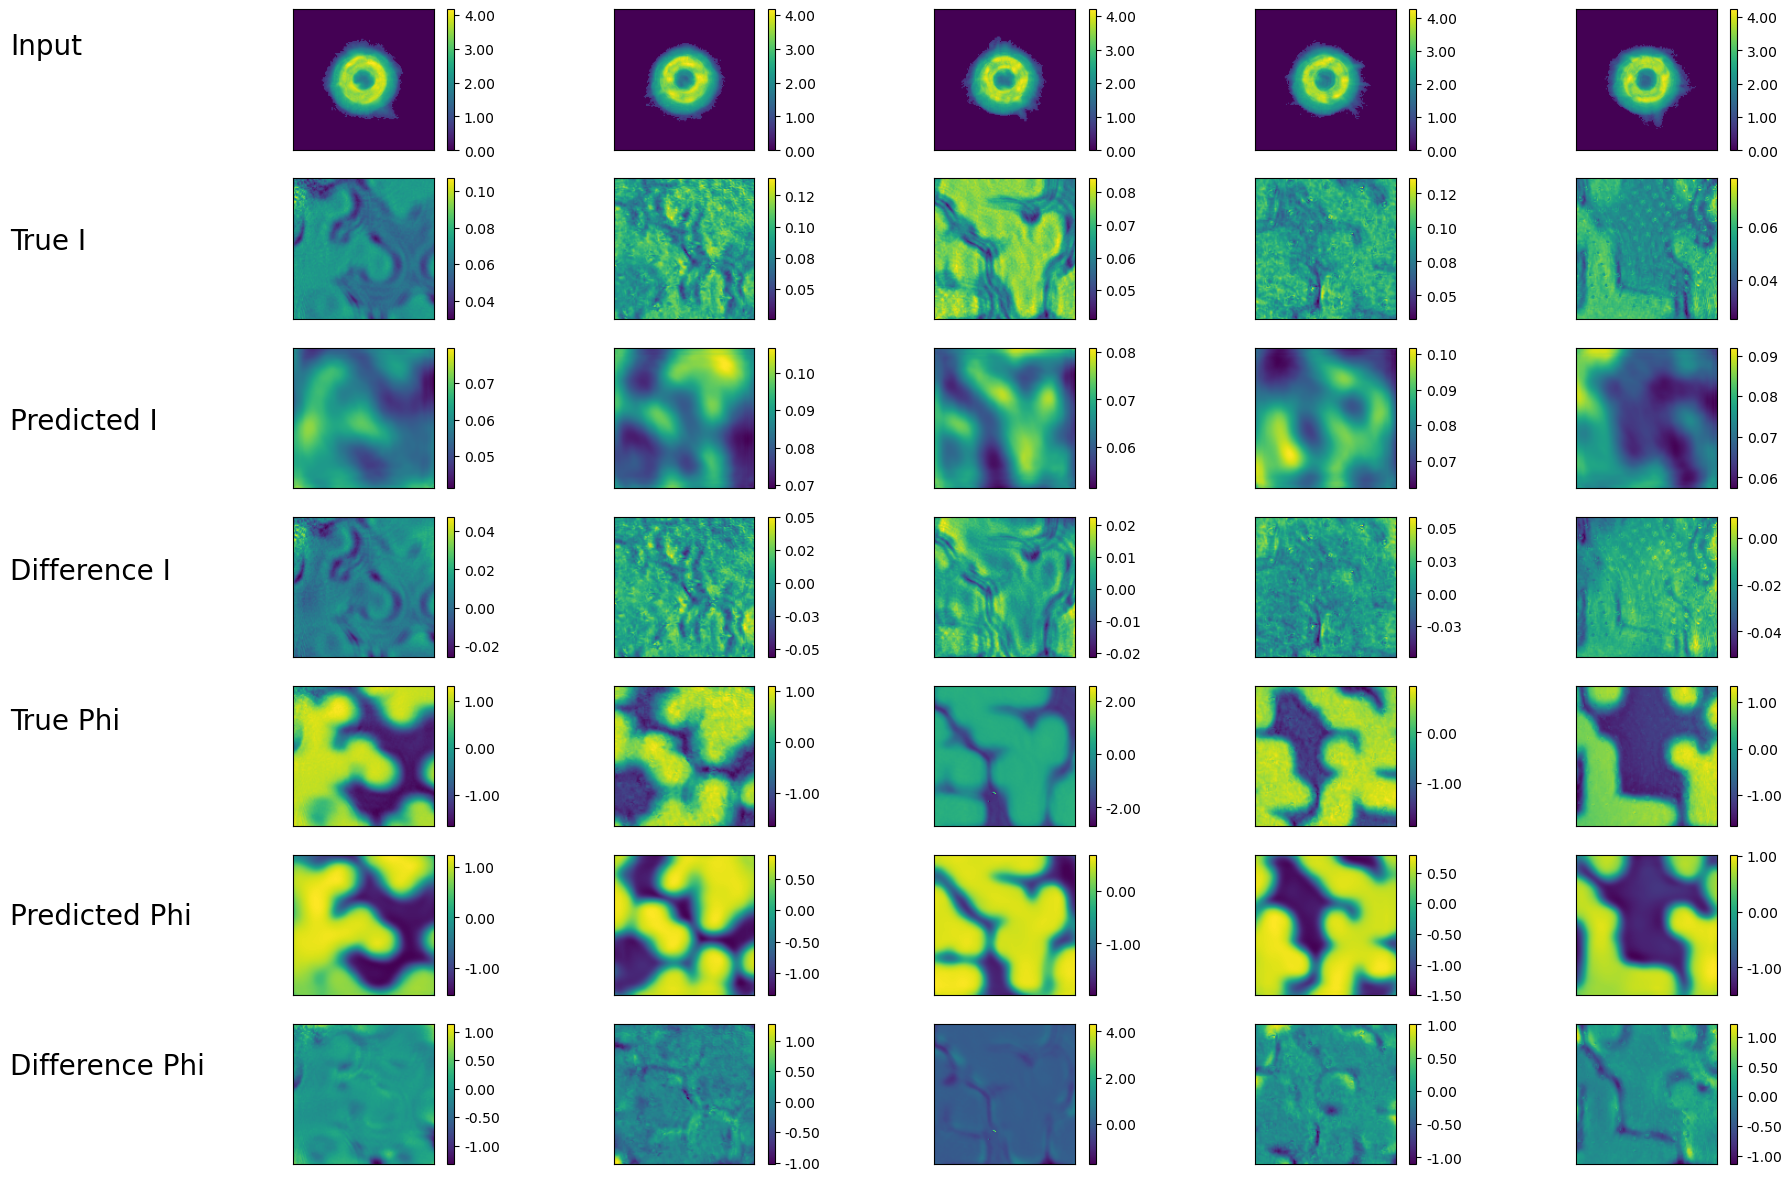

In [10]:
trainer.run_testing((0, 1000, 2000, 3000, 4000), dataset='train')